# 0. Imports

### 0.1 Libs

In [50]:
import math
import datetime
import inflection
import numpy        as np
import pandas       as pd
import seaborn      as sns

from tabulate               import tabulate
from scipy                  import stats as ss
from matplotlib             import pyplot as plt
from matplotlib.gridspec    import GridSpec
from IPython.display        import Image
from sklearn.preprocessing  import RobustScaler, MinMaxScaler, LabelEncoder

sns.set(rc={'figure.figsize':(20,10)})

### 0.2 Helper Functions

In [2]:
#Função para definir a correlação entre variáveis categóricas: 

# É feita utilizando o metodo "Cramér's V", onde:
    #v = np.sqrt ( (chi2/n) / (min(k-1, r-1)) )
        # Chi2 deriva do teste estatístico de Pearson 
        # n é o número de amostras
        #'K-1' é o número de colunas menos 1 e 'r-1' é o número de linhas -1

# Diferente da correlação de Pearson para variáveis numéricas, que vai de '-1 a 1', o Cramér's V vai de '0 a 1' 

def cramer_v(x,y):
    cm = pd.crosstab( x, y).values               # Confusion Matrix (cm) - tabela de contingência
    n = cm.sum()                                 # n é o número de amortras
    r, k = cm.shape                              #'K' é o número de colunas e 'r' é o número de linhas
    chi2 = ss.chi2_contingency(cm)[0]
        # Linha 0: resultado do teste de chi2
        # Linha 1: resultado do p-valor
        # Linha 2: número de graus de liberdade
        # Linha 3: tabela de frequência

    chi2corr = max( 0, chi2 - ((k-1)*(r-1))/(n-1) )
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)

    # Cálculo do Cramér's V:
    return np.sqrt ( (chi2corr/n) / (min(kcorr-1, rcorr-1)) )

### 0.3 Loading data

In [3]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1. Descrição dos Dados

### 1.1 Rename Columns

In [4]:
# Criando cópia de segurança
df1 = df_raw.copy()

df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [5]:
#Função para renomear as colunas (alterando de CammelCase para snake_case):

cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list( map(snakecase, cols_old))

df1.columns = cols_new

df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

### 1.2 Data Dimensions

In [6]:
print(f'Number of Rows:{df1.shape[0]}')
print(f'Number of Columns:{df1.shape[1]}')


Number of Rows:1017209
Number of Columns:18


### 1.3 Data Types

In [7]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

### 1.4 Check NA

In [8]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.5 Fillout NA

In [9]:
#competition_distance (distância entre a loja mais próxima):
    # Nesse caso, as columas com NA indicam lojas que não tem concorrente próxima. Subtituímos então o NA por uma distância muito grande (200.000 metros). 
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

#promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map (month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

            

### 1.6 Change Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

### 1.7 Estatística Descritiva

##### 1.7.0 Definindo datasets

In [11]:
# Definindo datasets:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

##### 1.7.1 Numerical Attributes

In [12]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concatenate
m = pd.concat( [ d2, d3, d4, ct1, ct2, d1, d5, d6 ] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


##### 1.7.2 Categorical Attributes

In [13]:
#Quantidade de valores para cada variável categorica:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

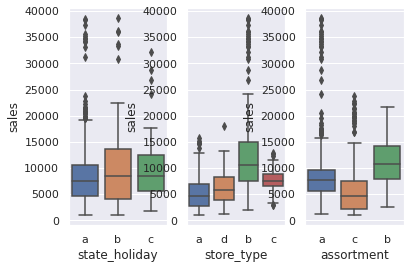

In [14]:
# Visualização dos dados:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

O gráfico do boxplot é uma forma de interpretar variáveis categoricas. O traço dentro do gráfico é a mediana, abaixo dele esta o segundo quartil e acima o terceiro quartil. Os traços nas extremidades indicam o máximo e o mínimo da série e os pontos acima dos traços máximos são os "outliers" da distribuição (3x o desvio padrão).

Interpretações:
- os feriado b e c possuem medianas muito parecidas, porém a curva normal do feriado b é mais homogênia enquando no c é mais deslocada para o terceiro quartil
- o tipo de loja b tem a mediana de vendas muito maior que as demais e mais pontos outliers na curva
- o mix de produtos b tem uma mediana maior, porém, em a temos mais outliers

# 2. Feature Engineering

### 2.1 Mapa mental de hipoteses

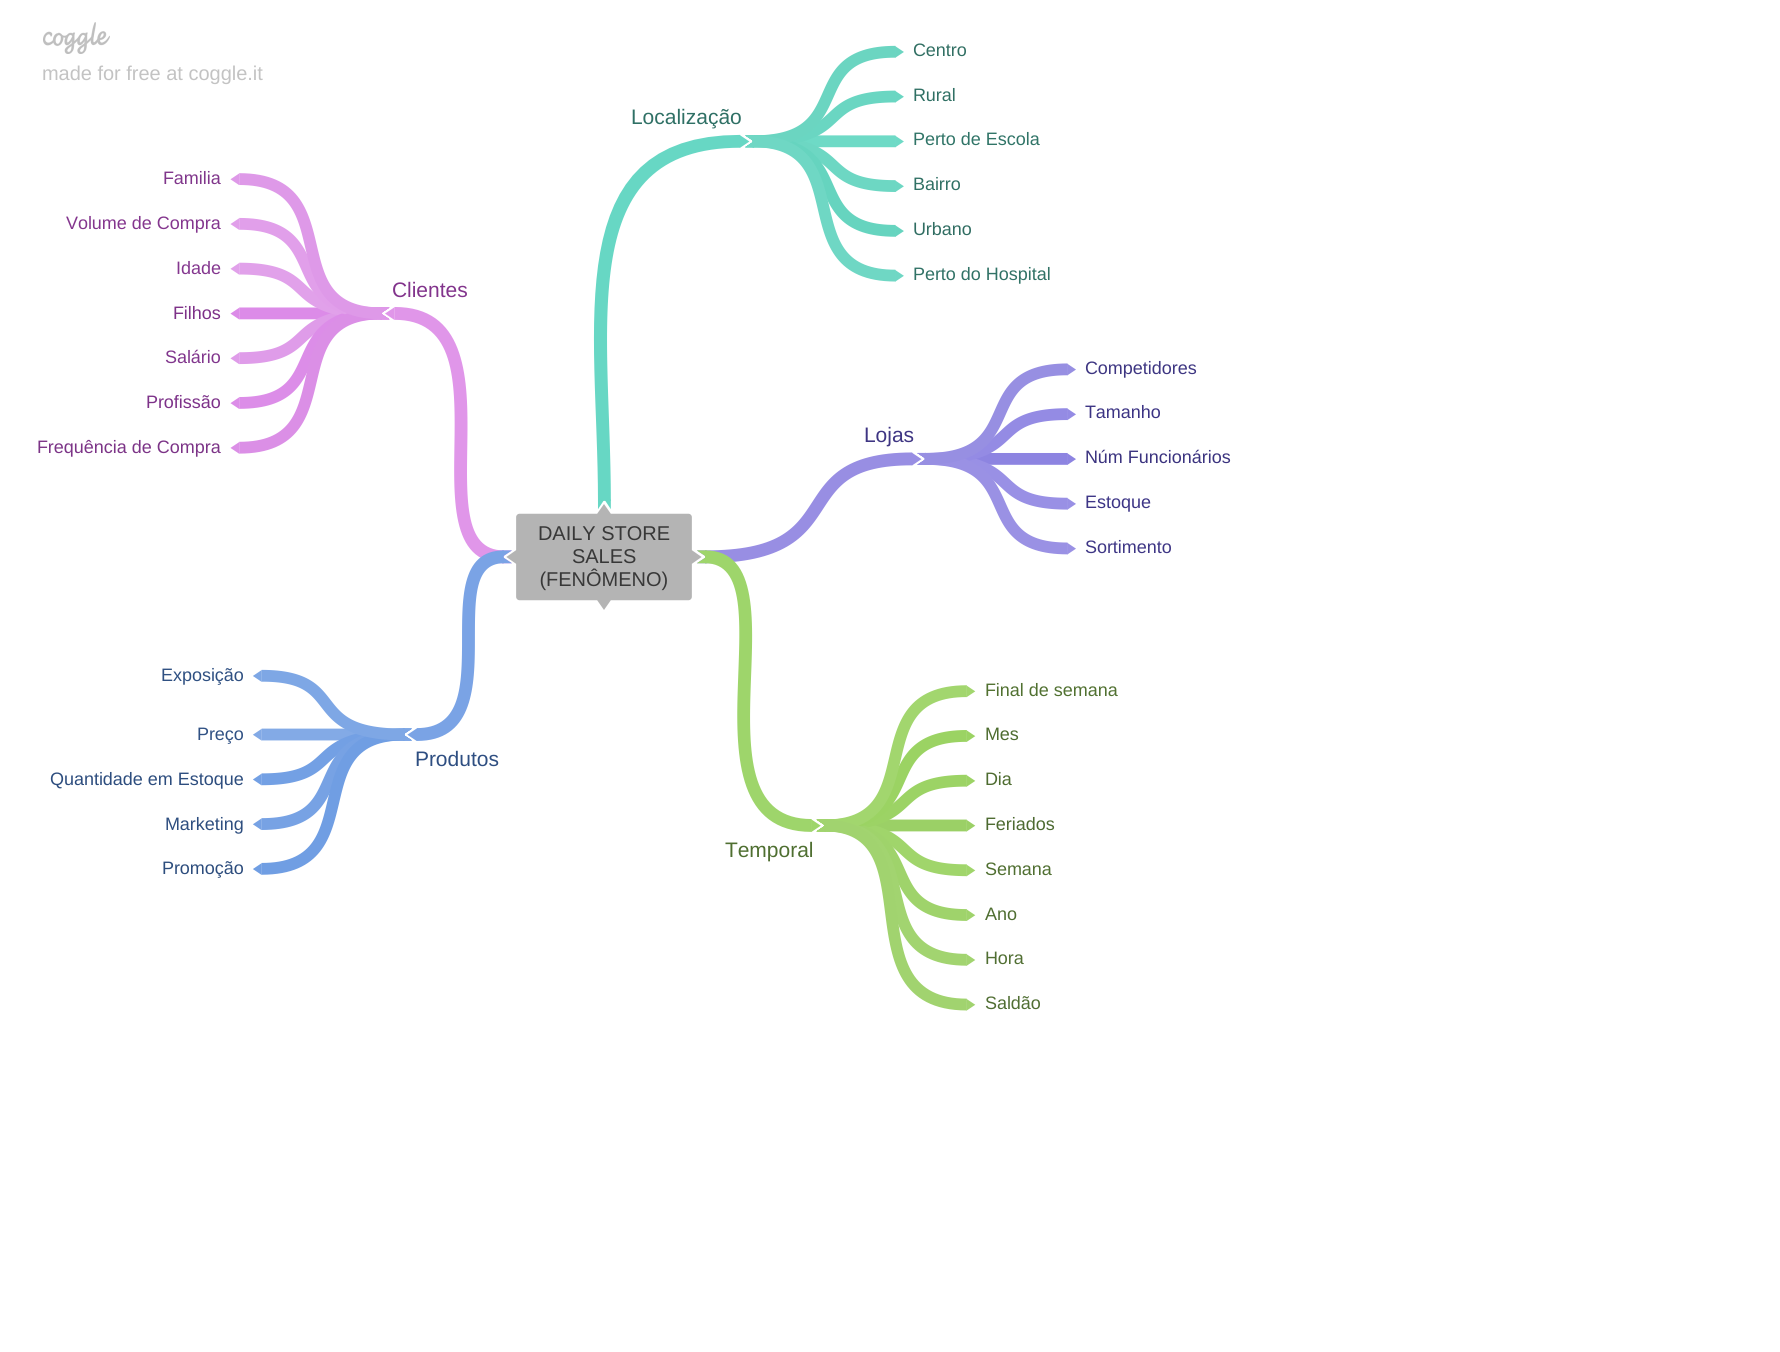

In [15]:
Image('img/MindMapHypothesis.png')

### 2.2 Criação de Hiposes

##### 2.2.1 Hipoteses Loja

1. Lojas com número maior de funcionários deveriam vender mais.
2. Lojas com maior capacidade de estoque deveriam vender mais.
3. Lojas com maior porte deveriam vender mais.
4. Lojas com maior sortimentos deveriam vender mais.
5. Lojas com competidores mais próximos deveriam vender menos.
6. Lojas com competidores à mais tempo deveriam vendem mais.

##### 2.2.2 Hipoteses Produto

1. Lojas que investem mais em Marketing deveriam vender mais.
2. Lojas com maior exposição de produto deveriam vender mais.
3. Lojas com produtos com preço menor deveriam vender mais.
5. Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.
6. Lojas com promoções ativas por mais tempo deveriam vender mais.
7. Lojas com mais dias de promoção deveriam vender mais.
8. Lojas com mais promoções consecutivas deveriam vender mais.

##### 2.2.3 Hipoteses Tempo

1. Lojas abertas durante o feriado de Natal deveriam vender mais.
2. Lojas deveriam vender mais ao longo dos anos.
3. Lojas deveriam vender mais no segundo semestre do ano.
4. Lojas deveriam vender mais depois do dia 10 de cada mês.
5. Lojas deveriam vender menos aos finais de semana.
6. Lojas deveriam vender menos durante os feriados escolares.

### 2.3 Lista Final de Hipóteses

1. Lojas com maior sortimentos deveriam vender mais.
2. Lojas com competidores mais próximos deveriam vender menos.
3. Lojas com competidores à mais tempo deveriam vendem mais.
4. Lojas com promoções ativas por mais tempo deveriam vender mais.
5. Lojas com mais dias de promoção deveriam vender mais.
6. Lojas com mais promoções consecutivas deveriam vender mais.
7. Lojas abertas durante o feriado de Natal deveriam vender mais.
8. Lojas deveriam vender mais ao longo dos anos.
9. Lojas deveriam vender mais no segundo semestre do ano.
10. Lojas deveriam vender mais depois do dia 10 de cada mês.
11. Lojas deveriam vender menos aos finais de semana.
12. Lojas deveriam vender menos durante os feriados escolares.

### 2.4 Featuring Engineering

In [16]:
df2 = df1.copy()

In [17]:
# Features derivadas do tempo:

# Year
df2['year'] = df2['date'].dt.year

# Month
df2['month'] = df2['date'].dt.month

# Day
df2['day'] = df2['date'].dt.day

# Week of Year
df2['week_of_year'] = df2['date'].dt.weekofyear

# Year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

/tmp/ipykernel_7351/4003102330.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [18]:
# Outras Features:

# Competition since (concatenar ano e mes e transfromar em data):
df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/ 30).apply(lambda x: x.days).astype(int)

# Promo since (concatenar ano e semana do ano e transformar em data):
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply (lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ( (df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# Assortment (subtituir a = 'basic'; b = 'extra'; c = 'extended')
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

# State Holiday (substituir a = 'public holiday; b = 'easter holiday'; c = 'christmas)
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public holiday' if x=='a' else 'easter holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')


# 3. Filtro de Variáveis

### 3.0 Cópia de Segurança

In [19]:
df3 = df2.copy()

In [20]:
df3.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 3.1 Filtragem das Linhas

1. Open != 0: temos que desenvolver o modelo considerando apenas os dias em que as lojas estarão abertas
2. Sales > 0: idem

Obs.: Restrições de Negócios são condições que precisamos desconsiderar para construir o moledo de ML

In [21]:
df3 = df3[(df3['open'] !=0) & (df3['sales'] > 0)]

### 3.2 Filtragem das Colunas

1. Customers: é uma restrição de negócios, ou seja, é uma informação que você não terá disponível no momento da predição.
2. Open: como foi filtrada acima, só tem valores =1 (indicando que a loja estava aberta naquele dia)
3. Promo_interval: coluna criada para derivar features
4. Month_map: idem 

In [22]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

# 4 Exploratory Data Analysis

### 4.0 Cópia de Segurança

In [23]:
df4 = df3.copy()

### 4.1 Analise Univariada

##### 4.1.1 Response Variable

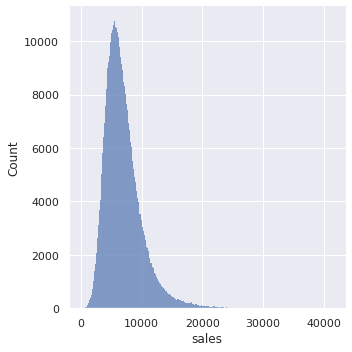

In [24]:
sns.displot(df4['sales'])

# Dados sejam independentes e normalmente distribuídos, ou seja, sigam uma distribuição normal. Então quanto mais normal for a variável resposta, melhor o algoritimo vai performar.

##### 4.1.2 Numerical Variable

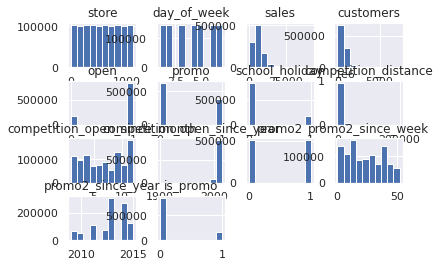

In [25]:
num_attributes.hist();

##### 4.1.3 Categorical Variable

In [26]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public holiday
129424    easter holiday
241126         christmas
Name: state_holiday, dtype: object

/home/vitor/.pyenv/versions/3.9.0/envs/SalesForecast/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

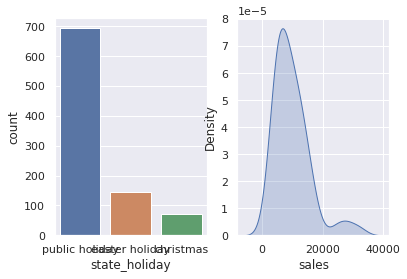

In [27]:
# state_holiday
plt.subplot(1, 2, 1)

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday']);

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label ='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label ='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']     ['sales'], label ='christmas'     , shade=True)

/home/vitor/.pyenv/versions/3.9.0/envs/SalesForecast/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

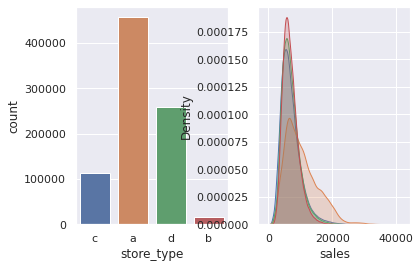

In [28]:
# store_type
plt.subplot(1, 2, 1)

sns.countplot(df4['store_type'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label ='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label ='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label ='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label ='d', shade=True)



/home/vitor/.pyenv/versions/3.9.0/envs/SalesForecast/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='sales', ylabel='Density'>

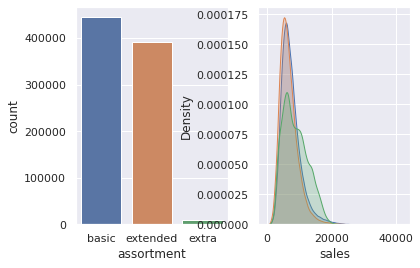

In [29]:
# assortment

plt.subplot(1, 2, 1)

sns.countplot(df4['assortment'])

plt.subplot(1, 2, 2)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label ='a', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label ='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label ='extra', shade=True)


### 4.2 Analise Bivariada

##### H1. Lojas com maior sortimentos deveriam vender mais.
**FALSA**: lojas com assortment extra vendem menos.

<AxesSubplot:xlabel='assortment', ylabel='sales'>

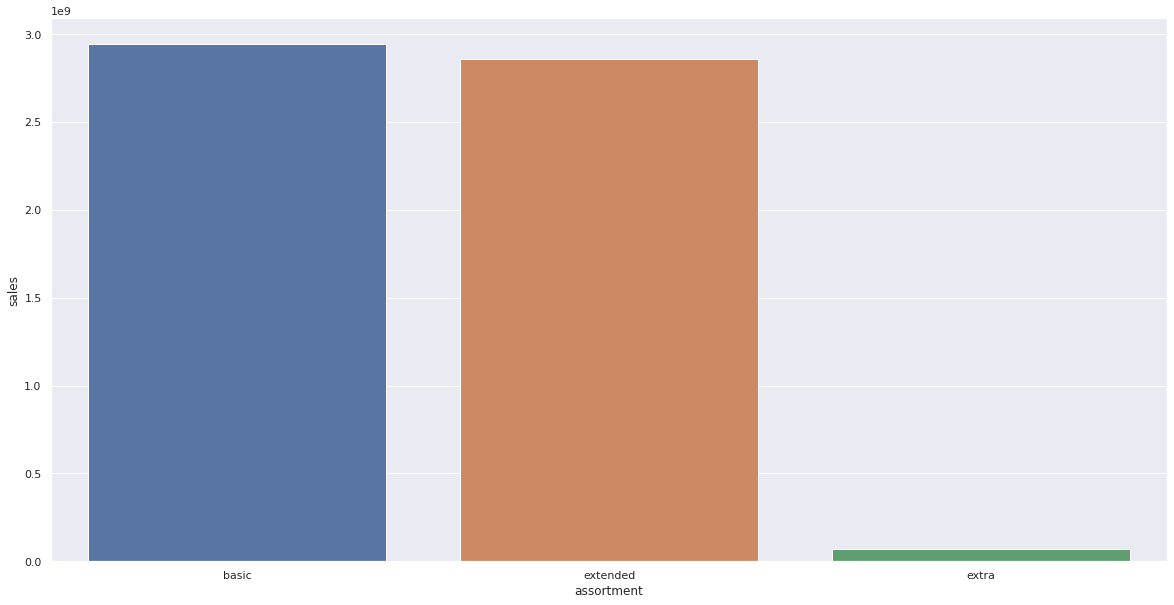

In [51]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

<AxesSubplot:xlabel='year_week'>

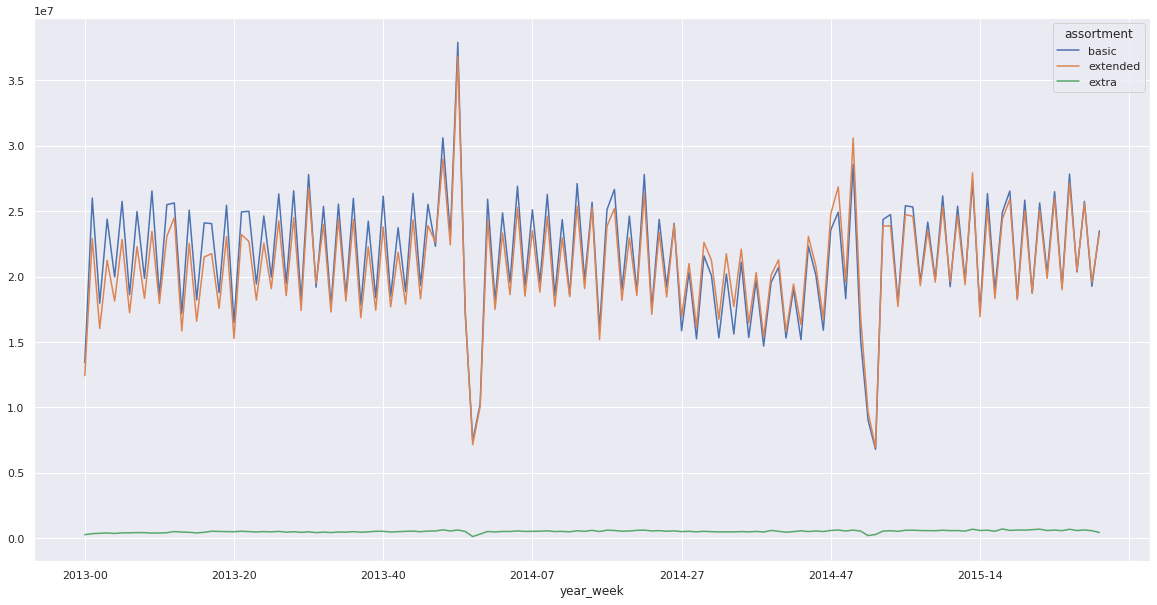

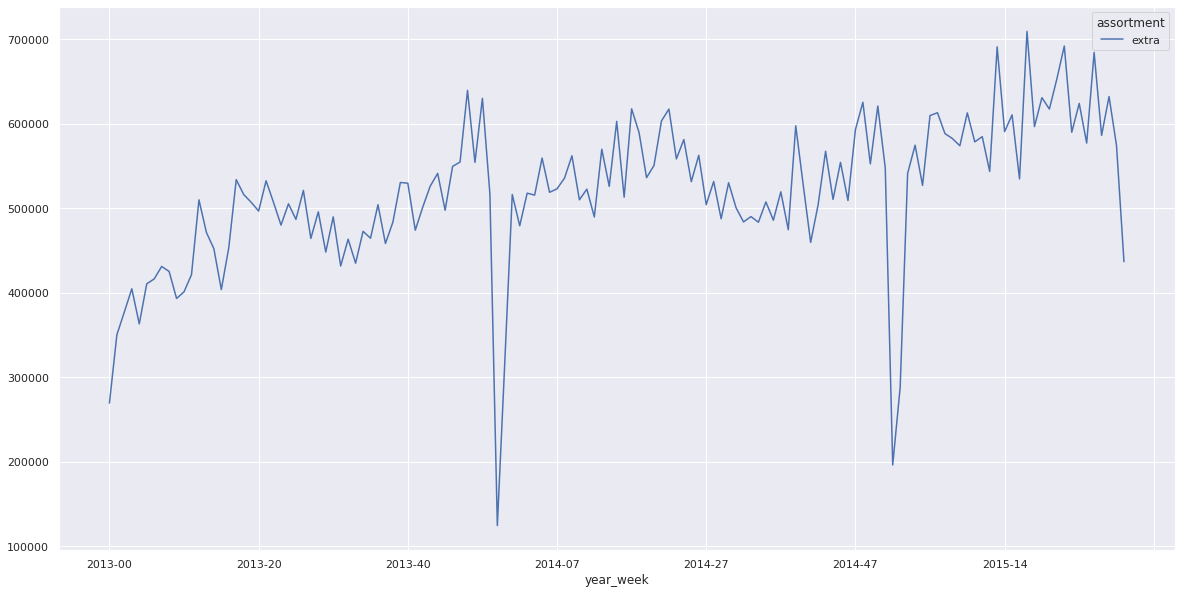

In [52]:
aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns = 'assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns = 'assortment', values='sales').plot()

##### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA**: competidores mais próximos vendem mais.


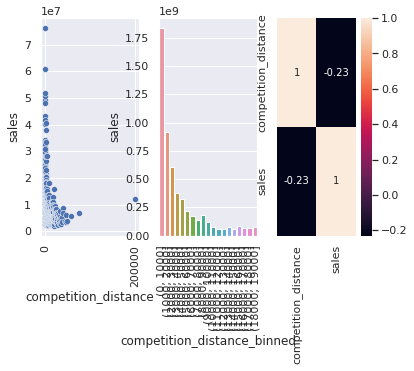

In [32]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y = 'sales', data=aux1);
plt.xticks (rotation=90);

plt.subplot(1,3,2)
#agrupando as distancias dos competidores em grupos de 1000 em 1000 metros:  
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks (rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


##### H3. Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA**: lojas com competidores a mais tempo vendem menos.

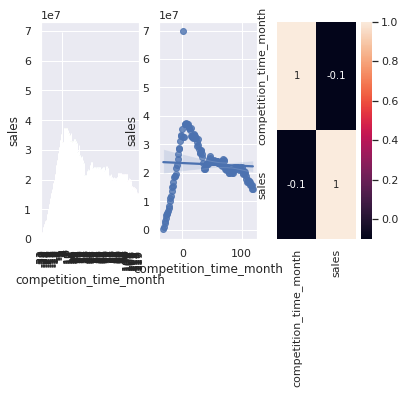

In [33]:

plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

##### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA**: a loja vende regularmente por um intervalo de tempo e depois começa a cair.


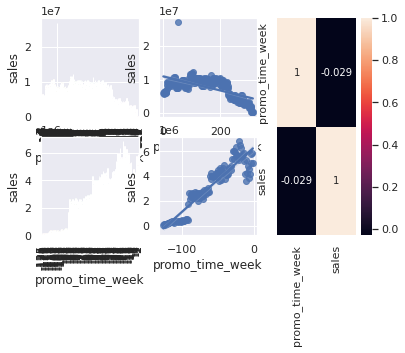

In [34]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promoção com período extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promoção sem período extendido
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);
#correlação fraca (abaixo de 0,1), provavelmente por conta do período estável que tem depois que inicia a promoção extendida.

##### H5. Lojas com mais dias de promoção deveriam vender mais.


Como é parecida com a hipotese anterior, vamos analisar ela no próximo ciclo do CRISP

##### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA**: lojas com mais promoções consecutivas vendem menos.

In [35]:
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


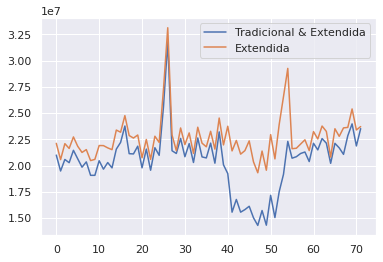

In [36]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)] [['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)] [['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels=['Tradicional & Extendida', 'Extendida']);



##### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
***FALSO**: lojas abertas no feriado de natal vendem menos

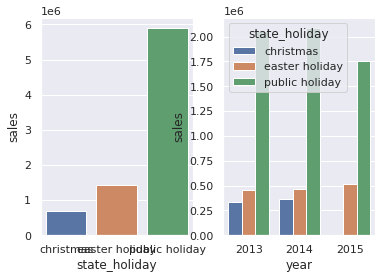

In [37]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x = 'state_holiday', y = 'sales', data=aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);


##### H8. Lojas deveriam vender mais ao longo dos anos.
**FALSA**: lojas vendem menos ao longo dos anos.

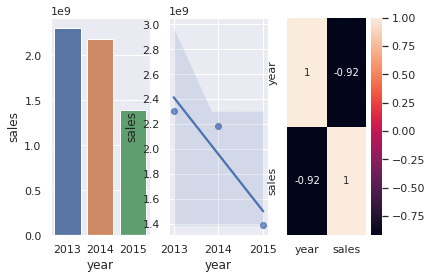

In [38]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'year', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

##### H9. Lojas deveriam vender mais no segundo semestre do ano.
**FALSA**: lojas vendem menos no segundo semestre do ano.

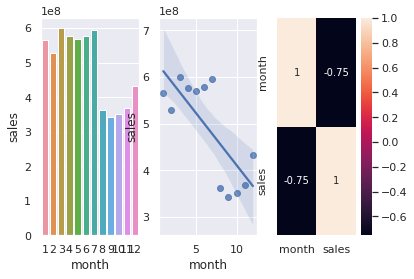

In [39]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'month', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

##### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA**: lojas vedem mais depois do dia 10 de cada mês

<AxesSubplot:xlabel='before_after', ylabel='sales'>

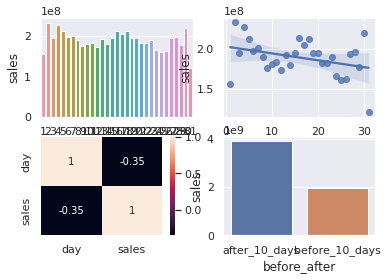

In [40]:
#Analise da evolução DoD:

aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,2)
sns.regplot(x = 'day', y = 'sales', data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

# Comparativo entre antes e depois do dia 10:
plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<=10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()
sns.barplot(x = 'before_after', y = 'sales', data = aux2)

##### H11. Lojas deveriam vender menos aos finais de semana.
**FALSA**: lojas vendem menos aos finais de semana

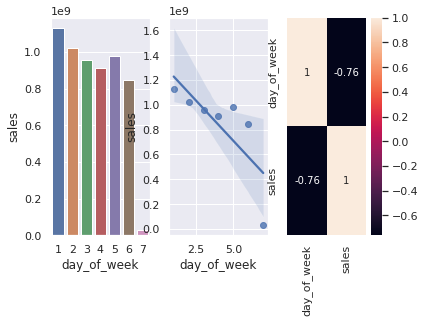

In [41]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,2)
sns.regplot(x = 'day_of_week', y = 'sales', data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot = True);

##### H12. Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA**: vendem menos durante os feriados escolares, exceto nos meses de ferias (julho e agosto)

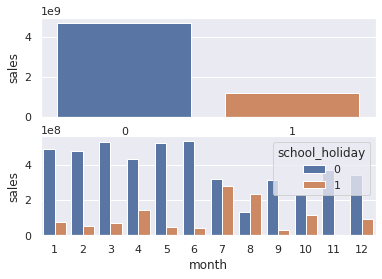

In [42]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

plt.subplot(2,1,2)
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);


##### 4.2.1 Resumo das Hipoteses

In [43]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


### 4.3 Analise Multivariada

##### 4.3.1 Numerical Atributes

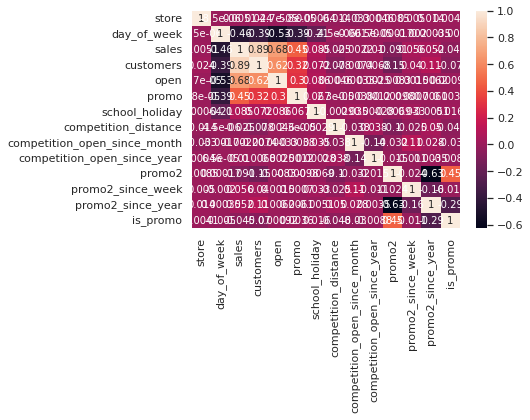

In [44]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation , annot = True);

##### 4.3.1 Categorical Atributes

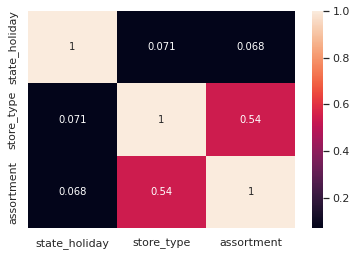

In [45]:
# Only categorical data:
a = df4.select_dtypes(include = 'object')

# Calculate Cramér's V:
a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type':    [a4, a5, a6],
                  'assortment':    [a7, a8, a9]})

d = d.set_index(d.columns)

sns.heatmap (d, annot = True);

# 5.Preparação dos Dados

### 5.1 Normalização

In [60]:
# Cópia de segurança
df5 = df4.copy()

Pela análise da sesão 4.1.2 Numerical Variable, não temos nenhuma variável com uma distribuição normal, dessa forma a normalização não se aplicaria a nenhuma das features.

### 5.2 Rescaling

In [61]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance: possuem outliers bem definidos (foram inseridos na limpeza dos dados), dessa forma, vamos usar o Robust Scaler para fazer o rescaling.
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

# competition time month: também tem bastante outliers, também será utilizado o Robust Scaler
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

# promo time week: não possuem outliers tão relevantes, então vamos utilizar o Min-Max Scaler
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)


### 5.3 Transformação

##### 5.3.1 Encoding

In [62]:
# state_holiday: momentos pontuais em que o comportamento da variável resposta muda. Nesse caso o método mais indicado é o One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store_type: como não sabemos o que representa cada código do store_type (a, b, c, d) vamos utilizar o Label Encoding, que numera variáveis sem hierarquia entre elas.
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment: como existe relação entre as variáveis categoricas do assortment, vamos usar o Ordinal Encoding
assortment_dict = {'basic':1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)


##### 5.3.2 Response Variable Transformation

/home/vitor/.pyenv/versions/3.9.0/envs/SalesForecast/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


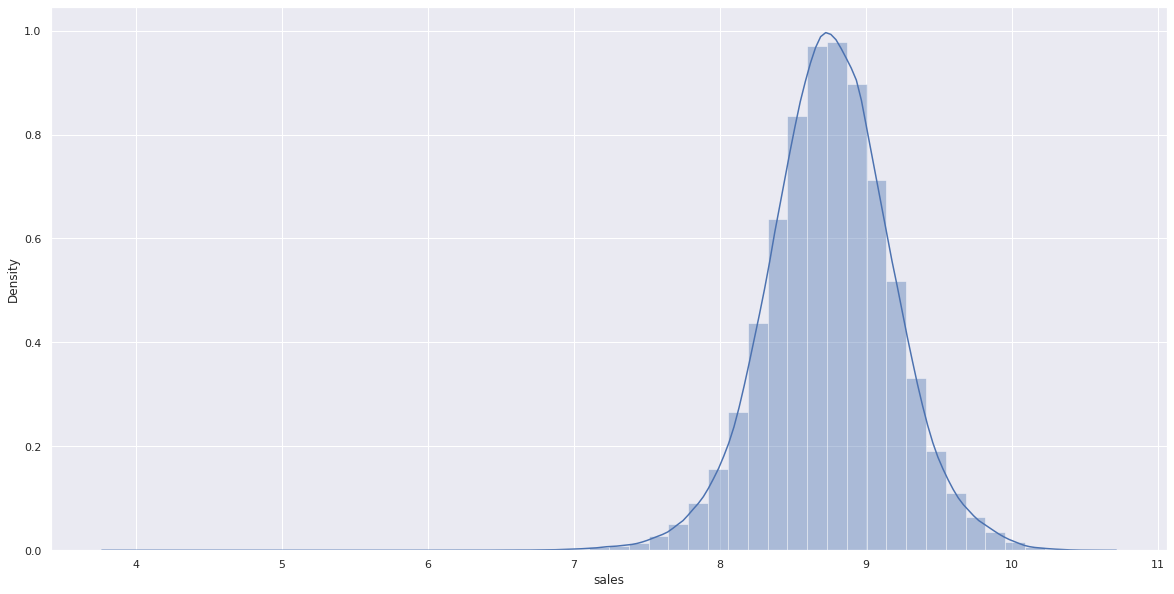

In [63]:
df5['sales'] = np.log1p(df5['sales'])
sns.distplot(df5['sales']);

##### 5.3.3 Nature Transformation

In [64]:
# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x*( 2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x*( 2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x*( 2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x*( 2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x*( 2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x*( 2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x*( 2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x*( 2. * np.pi/7 ) ) )
